In [1]:
import torch
import copy
import json
import os

import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import torch.optim as optim
import mediapipe as mp
import torch.nn as nn
import pandas as pd
import numpy as np

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange

# Selecting a device for training

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", DEVICE)

Current device: cuda


# Settings

In [3]:
# File directories
DATA_DIR       = './asl-signs/'
LANDMARK_FILES = 'train_landmark_files'
CSV_FILE       = 'train.csv'
ID_TO_SIGN_MAP = 'sign_to_prediction_index_map.json'

#Dataset settings
VAL_PART    = 0.1
SHUFFLE     = True
MAX_ROWS    = 100
BATCH_SIZE  = 128
NUM_WORKERS = 0
PIN_MEMORY  = False
NUM_CLASSES = 250

# Training settings
LR           = 5e-3
WEIGHT_DECAY = 5e-5
NUM_EPOCHS   = 30

# Scheduler settings
T_0     = 1
T_MULT  = 2
ETA_MIN = 5e-5

# Distribution of classes in the dataset

In [4]:
parquets = pd.read_csv(os.path.join(DATA_DIR, CSV_FILE))
parquets.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


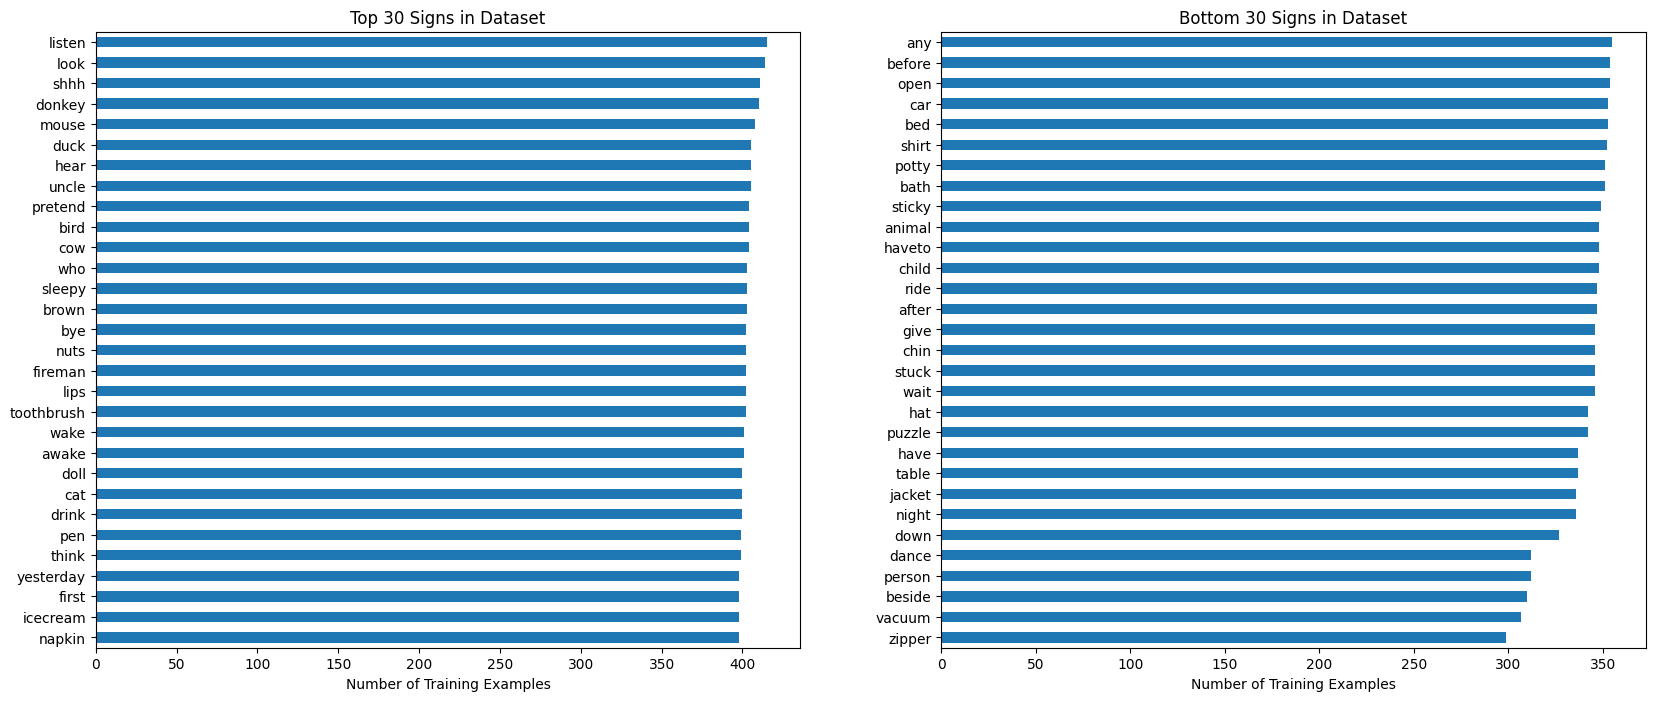

In [5]:
NUM_2_SHOW = 30

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

parquets['sign'].value_counts().head(NUM_2_SHOW).sort_values(ascending = True).plot(
    kind = "barh", title = f'Top {NUM_2_SHOW} Signs in Dataset', xlabel = 'Number of Training Examples', ax = ax1)

parquets['sign'].value_counts().tail(NUM_2_SHOW).sort_values(ascending = True).plot(
    kind = "barh", title = f'Bottom {NUM_2_SHOW} Signs in Dataset', xlabel = 'Number of Training Examples', ax = ax2)

plt.show()

# Class indexes

In [6]:
def read_json(path):
    
    with open(path, "r") as file:
        json_data = json.load(file)
        
    return json_data

In [7]:
sign_2_id_map = read_json(os.path.join(DATA_DIR, ID_TO_SIGN_MAP))
id_2_sign_map = {id: sign for sign, id in sign_2_id_map.items()}

In [8]:
parquets['id'] = parquets["sign"].map(lambda sign: sign_2_id_map[sign])
parquets.head()

,path,participant_id,sequence_id,sign,id
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


# Landmark data example

In [9]:
EXAMPLE_SIGN  = 'shhh'

lms = parquets.query(f'sign == "{EXAMPLE_SIGN}"')['path'].values[0]
lms = pq.read_table(os.path.join(DATA_DIR, lms)).to_pandas().dropna()

lms.head()

,frame,row_id,type,landmark_index,x,y,z
0,14,14-face-0,face,0,0.432380,0.375417,-0.044000
1,14,14-face-1,face,1,0.437980,0.349091,-0.070176
2,14,14-face-2,face,2,0.429624,0.360922,-0.040331
3,14,14-face-3,face,3,0.430260,0.315678,-0.049688
4,14,14-face-4,face,4,0.441155,0.338613,-0.073218


In [10]:
lms = lms.drop(columns = ['row_id'], axis = 1)
lms = pd.get_dummies(lms, columns = ['type'], prefix = '', prefix_sep = '')

for type in ["face", "pose", "right_hand", "left_hand"]:
    if type not in lms:
        lms[type] = np.zeros(len(lms), dtype = 'uint8')

lms.head()

,frame,landmark_index,x,y,z,face,left_hand,pose,right_hand
0,14,0,0.432380,0.375417,-0.044000,1,0,0,0
1,14,1,0.437980,0.349091,-0.070176,1,0,0,0
2,14,2,0.429624,0.360922,-0.040331,1,0,0,0
3,14,3,0.430260,0.315678,-0.049688,1,0,0,0
4,14,4,0.441155,0.338613,-0.073218,1,0,0,0


# Visualization of Landmarks

In [11]:
def show_frame(df, label, frame_id):
    
    fig, axs = plt.subplots(1, 4, figsize = (24, 6))
    frame = df[df['frame'] == frame_id]

    hands_edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]
    
    pose_edges = [(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), 
                  (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), 
                  (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28),
                  (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)]

    for ax, type in zip(axs, ["face", "pose", "right_hand", "left_hand"]):
        
        if 'type' in frame:
            lm = frame.query(f'type == "{type}"')

        elif type in frame:
            lm = frame.query(f'{type} == 1')

        ax.set_title(type, fontsize = 15)
        ax.scatter(lm['x'], -lm['y'])

        xs     = lm['x'].values
        ys     = lm['y'].values
        lm_ids = lm['landmark_index'].values

        for x, y, id in zip(xs, ys, lm_ids):
            ax.text(x, -y, id, fontsize = 6)

        if (type == 'right_hand' or type == 'left_hand') and len(xs) > 0:
            for edge in hands_edges:
                ax.plot([xs[edge[0]], xs[edge[1]]], [-ys[edge[0]], -ys[edge[1]]], color = 'salmon')

        elif type == 'pose':
            for edge in pose_edges:
                ax.plot([xs[edge[0]], xs[edge[1]]], [-ys[edge[0]], -ys[edge[1]]], color = 'salmon')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.suptitle(f'Sign: "{label}", Frame: {frame_id}', fontsize = 20)

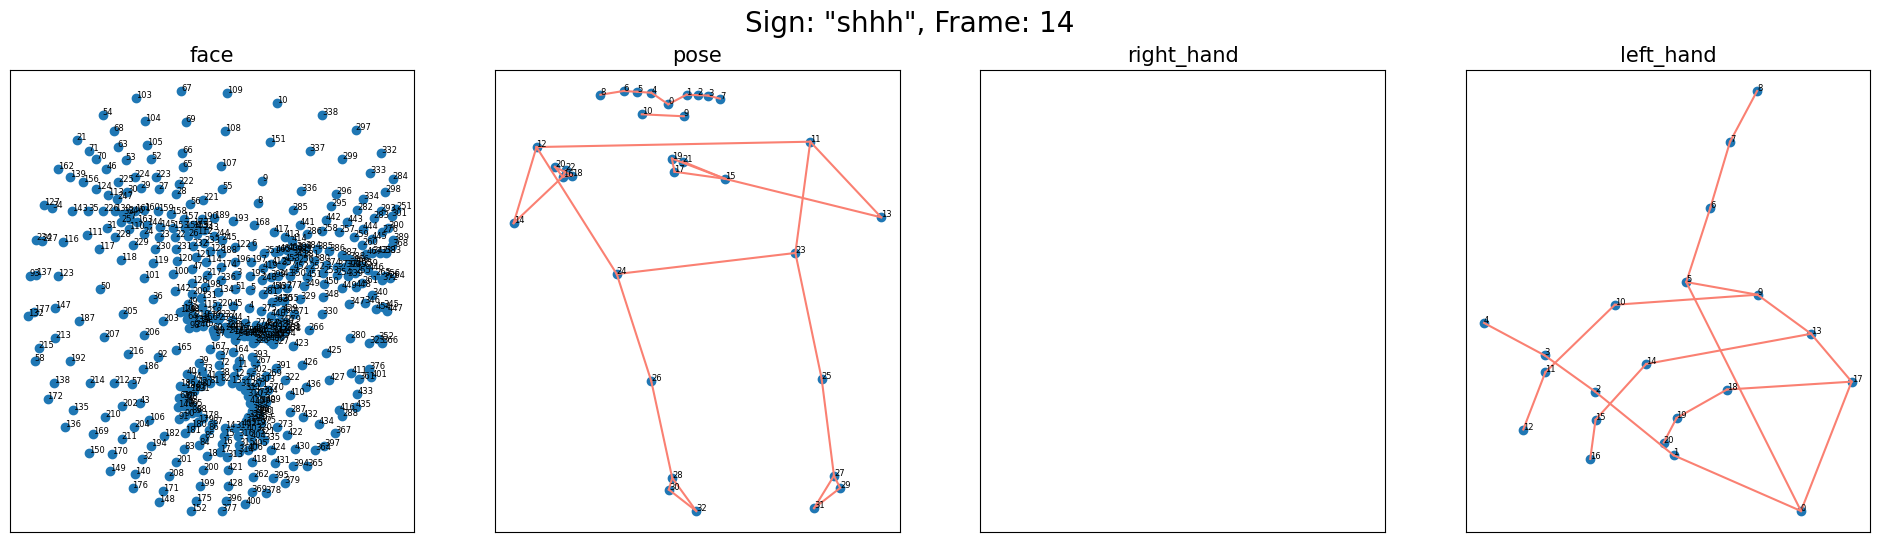

In [12]:
def show_frames_seq(df, label, start_frame, n_frames):

    frames = np.linspace(start_frame, start_frame + n_frames, n_frames, dtype = int, endpoint = True)

    for i in range(n_frames):
        show_frame(df, label, frames[i])
        
    plt.show()

show_frames_seq(lms, EXAMPLE_SIGN, lms['frame'][0], 1)

# Creating a dataset

In [13]:
class sign_Dataset(Dataset):
    
    def __init__(self, parq_dirs):
        self.parq_dirs = parq_dirs

    def __getitem__(self, id):
        
        lms = pq.read_table(os.path.join(DATA_DIR, self.parq_dirs.iloc[id]['path'])).to_pandas().dropna()

        lms = lms.drop(columns = ['row_id'], axis = 1)
        lms = pd.get_dummies(lms, columns = ['type'], prefix = '', prefix_sep = '')

        for type in ["face", "pose", "right_hand", "left_hand"]:
            if type not in lms:
                lms[type] = np.zeros(len(lms), dtype = 'uint8')

        return lms.sample(MAX_ROWS).to_numpy(), self.parq_dirs.iloc[id]['id']

    def __len__(self):
        return len(self.parq_dirs)

# Split train.csv for training and validation

In [14]:
dataset = sign_Dataset(parquets)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))

n_val   = int(np.floor(VAL_PART * dataset_size))
n_train = dataset_size - n_val

if SHUFFLE :
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[n_val:], indices[:n_val]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler   = SubsetRandomSampler(val_indices)

# Creating a Dataloader

In [15]:
data_loader = {
    'train':
        DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY),
    'valid':
        DataLoader(dataset, batch_size = BATCH_SIZE, sampler = val_sampler, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
}

df, label = next(iter(data_loader['train']))
print(df.shape)
print(label.shape)

torch.Size([128, 100, 9])
torch.Size([128])


# Creating a model

In [16]:
class Net(nn.Module):
    
    def __init__(self, in_features, num_classes):
        super(Net, self).__init__()

        self.l1 = nn.Sequential(nn.Linear(in_features, 128),
                               nn.BatchNorm1d(128),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        self.l2 = nn.Sequential(nn.Linear(128, 64),
                               nn.BatchNorm1d(64),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        self.l3 = nn.Sequential(nn.Linear(64, 32),
                               nn.BatchNorm1d(32),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        self.l4 = nn.Sequential(nn.Linear(32, 16),
                               nn.BatchNorm1d(16),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        self.l5 = nn.Sequential(nn.Linear(16, num_classes),
                               nn.BatchNorm1d(num_classes),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        # self.fc1 = nn.Linear(9, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, 32)
        # self.fc4 = nn.Linear(32, 16)
        # self.fc5 = nn.Linear(16 * 100, 250)
        # self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(0)

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        # x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        # x = self.relu(self.fc4(x))
        # x = self.flatten(x)
        # x = self.fc5(x)

        # return self.softmax(x)
        return x
    
model = Net(df.shape[1] * df.shape[2], NUM_CLASSES).to(DEVICE)

In [17]:
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = T_0, T_mult = T_MULT, eta_min = ETA_MIN)

In [18]:
train_losses = []
val_losses   = []
train_acc    = []
val_acc      = []

lr = [LR]

def train_model(model, criterion, optimizer, num_epochs = NUM_EPOCHS):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in (pbar := trange(num_epochs)):

        for phase in['train', 'valid']:

            if phase == 'train':
                model.train()

            else:
                model.eval()

            running_loss     = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(data_loader[phase], position = 1):
                inputs = inputs.float().to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                loss    = criterion(outputs, labels)

                if phase == 'train':                   
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()


                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            lr_scheduler.step()
            lr.append(optimizer.param_groups[0]["lr"])

            epoch_loss = running_loss / len(data_loader[phase])
            epoch_acc  = running_corrects.double() / len(data_loader[phase]) * 100
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
                
                if best_acc < epoch_acc: 
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, './best_model.pth')
       
        pbar.set_description(
            f'Avg. train/valid loss: [{train_losses[epoch]:.2f}/{val_losses[epoch]:.2f}], train/valid Accuracy: [{train_acc[epoch]:.2f}%/{val_acc[epoch]:.2f}%]')
        
    return model.load_state_dict(best_model_wts)

model = train_model(model, criterion, optimizer)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def legend(list_1, label_1, step, title, list_2 = None, label_2 = None):

    plt.plot(list_1[1:], label = label_1)

    if list_2 is not None:
        plt.plot(list_2[1:], label = label_2)

    plt.xticks(range(1, NUM_EPOCHS + step, step))
    plt.xlabel('Iterations')
    plt.ylabel(title)

    plt.legend()
    plt.show()

legend(list_1 = train_losses, label_1 = 'Train', step = 5, title = 'Loss', list_2 = val_losses, label_2 = 'Valid')
legend(list_1 = train_acc, label_1 = 'Train', step = 5, title = 'Accuracy', list_2 = val_acc, label_2 = 'Valid')
legend(list_1 = lr, label_1 = 'Lr', step = 5, title = 'Learning rate')